# Practical Assignment 1

We'll start by importing the necessary dependancies and setup the parameters for training:

In [56]:
%matplotlib inline
import utils
from chainer import optimizers
from MLP import MLP
import chainer
from Classifier import Classifier
from chainer import Chain
import chainer.functions as F
import chainer.links as L
import matplotlib.pyplot as plt

n_hidden = 10
n_output = 10
n_epochs = 20
batch_size = 32

train_loss_list = []
test_loss_list = []

We will train the network using batches, these are retrieved from the dataset using the iterator that was supplied through Blackboard

In [57]:
# Import whole dataset
train, test = chainer.datasets.get_mnist()
train_iter = utils.RandomIterator(train, batch_size)
test_iter = utils.RandomIterator(test, batch_size)

The model that was used is a Multilayer Percepton Network (MLP) with one hidden layer:

In [58]:
class MLP(Chain):
    """
        Neural Network Definition, Multilayer Perceptron
        l1: fully connected hidden layer
        l2: output layer
    """
    def __init__(self, n_hidden, n_classes):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_hidden)   # input layer -> hidden layer
            self.l2 = L.Linear(None, n_classes)  # hidden layer -> output layer

    def __call__(self, x):
        """
        Feed the data in a forward fashion through the MLP
        :param x: Data
        :return: Last Link of the MLP
        """
        layer_hidden = F.relu(self.l1(x))
        layer_output = self.l2(layer_hidden)
        return layer_output


For classification we implemented our own Classifier that utilizes the _softmax cross entropy_ as the loss function:

In [59]:
class Classifier(Chain):
    def __init__(self, predictor):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, data, labels):
        y = self.predictor(data)
        self.loss = F.softmax_cross_entropy(y, labels)
        self.accuracy = F.accuracy(y, labels)
        return self.loss

This results in the following model where we uses Stochastic Gradient Descend as the optimizer for updating the model:

In [60]:
model = Classifier(MLP(n_hidden, n_output))
optimizer = optimizers.SGD()
optimizer.setup(model)

A function was then used to feed the data through the network, a parameter _update_ indicates if the model should update its parameters or just use the model for classification:

In [61]:
def feed_data(random_iter, update):
    """
    Feeds the network data
    :param random_iter: Iterator that holds the data
    :param update: Boolean whether to update the model parameters
    :return: loss and accuracy
    """
    total_loss = 0
    total_accuracy = 0

    for data in random_iter:
        x = data[0]
        labels = data[1]
        if update:
            optimizer.update(model, x, labels)
        else:
            model(x, labels)
        total_loss += float(model.loss.data)
        total_accuracy += float(model.accuracy.data)
    return total_loss / random_iter.idx, total_accuracy / random_iter.idx


The main function is _run_ which trains and tests the model, giving verbose output after each epoch which reports the accuracy and loss after each epoch:

In [62]:
def run():
    """
    Trains the MLP network for n_epochs.
    One epoch contains of a training phase and testing phase. Afterwards, the results are printed to the screen
    """
    for epoch in range(n_epochs):
        train_loss, train_accuracy = feed_data(train_iter, True)
        test_loss, test_accuracy = feed_data(test_iter, False)

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        print('Epoch {} \n'
              'Training: accuracy: {} \t loss: {} \n'
              'Testing: accuracy: {} \t loss: {}'.format(epoch + 1,
                                                         train_accuracy, train_loss,
                                                         test_accuracy, test_loss))


Finally we run the function and plot the training and test loss as a function of epochs:

In [63]:
run()

Epoch 1 
Training: accuracy: 0.75665 	 loss: 0.879573255721728 
Testing: accuracy: 0.8788060897435898 	 loss: 0.45016048858181024
Epoch 2 
Training: accuracy: 0.8852166666666667 	 loss: 0.41249142762819924 
Testing: accuracy: 0.8977363782051282 	 loss: 0.35839836330463487
Epoch 3 
Training: accuracy: 0.89895 	 loss: 0.3551220466931661 
Testing: accuracy: 0.9061498397435898 	 loss: 0.32616848914095986
Epoch 4 
Training: accuracy: 0.9072666666666667 	 loss: 0.3277586152712504 
Testing: accuracy: 0.9129607371794872 	 loss: 0.305908190110364
Epoch 5 
Training: accuracy: 0.9114666666666666 	 loss: 0.31024987579981483 
Testing: accuracy: 0.9177684294871795 	 loss: 0.2918626545713498
Epoch 6 
Training: accuracy: 0.9148333333333334 	 loss: 0.2983129698038101 
Testing: accuracy: 0.9189703525641025 	 loss: 0.2861500293111954
Epoch 7 
Training: accuracy: 0.91795 	 loss: 0.28897483872175217 
Testing: accuracy: 0.9213741987179487 	 loss: 0.2775839197043425
Epoch 8 
Training: accuracy: 0.92088333333

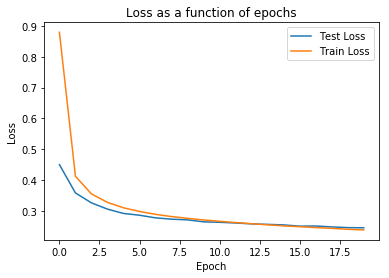

In [64]:
plt.plot(test_loss_list, label='Test Loss')
plt.plot(train_loss_list, label='Train Loss')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Loss as a function of epochs")
plt.show()

The loss gradually decreases over epochs as expected. The test loss starts much lower than the training loss, this is because the first testing happened after the first training phase.